In [1]:
%load_ext tensorboard

import os
import math
import datetime
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Our library
from rna_modification_detection.fast5 import Fast5
# pip install py3helpers[seq_tools] (my library)
from py3helpers.utils import list_dir


Num GPUs Available:  1


In [2]:
# set home and find test files
HOME = "/Users/andrewbailey/PycharmProjects/rna_modification_detection"
HOME = "/home/bailey/rna_modification_detection"

native_18S_dir = os.path.join(HOME, "tests/test_files/test_18S_full_length/nop58_fast5")
native_fast5_files = list_dir(native_18S_dir, ext="fast5")
ivt_18S_dir = os.path.join(HOME, "tests/test_files/test_18S_full_length/ivt_fast5")
ivt_fast5_files = list_dir(native_18S_dir, ext="fast5")

# native_18S_dir = os.path.join(HOME, "tests/test_files/test_18S_full_length/nop58_fast5/1000_nop58_fast5")
# native_fast5_files = list_dir(native_18S_dir, ext="fast5")
# ivt_18S_dir = os.path.join(HOME, "tests/test_files/test_18S_full_length/ivt_fast5/1000_ivt_fast5")
# ivt_fast5_files = list_dir(native_18S_dir, ext="fast5")



In [3]:
# read in test file 
fh = Fast5(native_fast5_files[0])
signal = fh.get_read(raw=True, scale=True)
events = pd.DataFrame(fh.get_signalalign_events(mea=True))
# signal = fh.get_read(raw=True, scale=False)
events.head()


,raw_start,raw_length,reference_index,posterior_probability,kmer
0,8987,17,1795,0.999949,b'ATTAC'
1,9004,21,1794,0.999949,b'TTACT'
2,9025,9,1793,0.999949,b'TACTA'
3,9034,11,1792,0.999949,b'ACTAG'
4,9045,25,1791,0.992518,b'CTAGG'


<IPython.core.display.Javascript object>


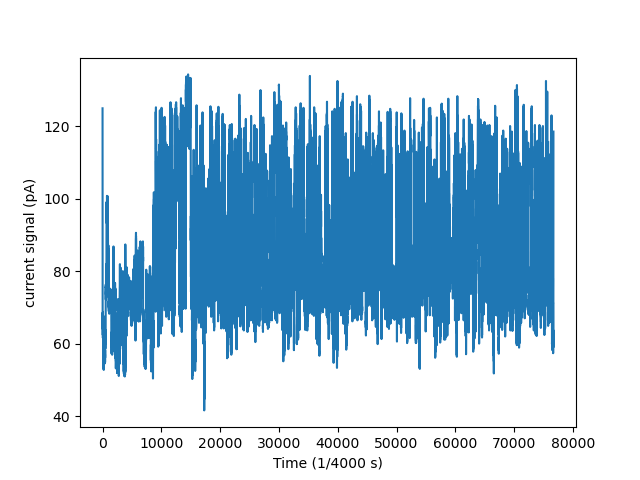

In [4]:
%matplotlib notebook
# plot signal and events data 
plt.plot(signal)
# plt.vlines(events["raw_start"], ymin = 50, ymax=150)
plt.ylabel('current signal (pA)')
plt.xlabel('Time (1/4000 s)')

plt.show()



In [87]:
fh = Fast5(native_fast5_files[0])
signal = fh.get_read(raw=True, scale=True)
events = pd.DataFrame(fh.get_signalalign_events(mea=True))
# signal = fh.get_read(raw=True, scale=False)
events.head()
ref_position = 796
kmer_length = 5
mod_signal_index = events[(ref_position-(kmer_length-1) <= events["reference_index"]) & (events["reference_index"] <= ref_position)]
print(mod_signal_index)

      raw_start  raw_length  reference_index  posterior_probability      kmer
1726      47413           7              796               0.617244  b'GTACG'
1727      47420           9              793               0.487980  b'CGATT'
1728      47429          19              793               0.117107  b'CGATT'
1729      47448           9              792               0.356701  b'GATTA'
1730      47457          20              792               0.105627  b'GATTA'


In [88]:
for x in mod_signal_index.groupby("reference_index"):
    start = x[1]["raw_start"].iloc[0]
    end = x[1]["raw_start"].iloc[-1]+x[1]["raw_length"].iloc[-1]
    print(start, end)

47448 47477
47420 47448
47413 47420


In [89]:
def get_events(fast5_file, ref_position, window=5):
    """Get a window of events around a given reference position
    :param fast5_file: path to fast5 file
    :param ref_position: integer reference position
    :param window: number of events to cover position
    """
    delta = window // 2
    #     read in file
    fh = Fast5(fast5_file)
    #     get events and signal
    signal = fh.get_read(raw=True, scale=True)
    signal = StandardScaler().fit_transform(np.array(signal).reshape(-1, 1))
    events = pd.DataFrame(fh.get_signalalign_events(mea=True))
    #     get signal index
    mod_signal_index = events[(ref_position-(window-1) <= events["reference_index"]) & (events["reference_index"] <= ref_position)]
#     print("n_ref_positions", len(set(mod_signal_index["reference_index"])))
    #     define window
    event_data = []
    for x in mod_signal_index.groupby("reference_index"):
        window_start = x[1]["raw_start"].iloc[0]
        window_end = x[1]["raw_start"].iloc[-1]+x[1]["raw_length"].iloc[-1]
        signal_window = signal[window_start:window_end]
        event_data.append(np.array([np.mean(signal_window), np.std(signal_window), window_end-window_start]))
    return np.array(event_data)



In [90]:
ref_position = 796
kmer_length = 5

print(len(get_events(native_fast5_files[0], ref_position, kmer_length)))

3


In [91]:
def get_raw_signal(fast5_file, ref_position, window=200):
    """Get a window of raw signal around a given reference position
    :param fast5_file: path to fast5 file
    :param ref_position: integer reference position
    :param window: number of current signals to collect (should be even)
    """
    delta = window // 2
#     read in file
    fh = Fast5(fast5_file)
    #     get events and signal
    signal = fh.get_read(raw=True, scale=True)
    signal = StandardScaler().fit_transform(np.array(signal).reshape(-1, 1))
#     signal = MinMaxScaler(feature_range=(0, 1)).fit_transform(np.array(signal).reshape(-1, 1))
    events = pd.DataFrame(fh.get_signalalign_events(mea=True))
    #     get signal index
    mod_signal_index = events[events["reference_index"] == ref_position].raw_start.iloc[0]
    #     define window
    window_start = mod_signal_index - delta
    window_end = mod_signal_index + delta 
    return signal[window_start:window_end]

In [92]:
# Train test split
train_size = int(len(native_fast5_files) * 0.67)
test_size = len(native_fast5_files) - train_size
mod_train, mod_test = native_fast5_files[0:train_size], native_fast5_files[train_size:len(native_fast5_files)]
ivt_train, ivt_test = ivt_fast5_files[0:train_size], ivt_fast5_files[train_size:len(native_fast5_files)]

print(len(mod_train), len(mod_test))
print(len(ivt_train), len(ivt_test))

6 4
6 4


In [100]:
# pick mod to predict
# This one has >95% modification status and I have predicted it well with other tools 
# 2’-O-Methyladenosine
ref_position = 796
# number of current signals to collect (should be even)
def create_dataset(mod_files, ivt_files, ref_position, window=200, function=get_raw_signal):
    dataX, dataY = [], []
    for file in mod_files:
        try:
            raw_signal = function(file, ref_position, window=window)
        except (KeyError, IndexError) as e:
            continue
        dataX.append(raw_signal)
        dataY.append(1)
    for file in ivt_files:
        try:
            raw_signal = function(file, ref_position, window=window)
        except (KeyError, IndexError) as e:
            continue
        dataX.append(raw_signal)
        dataY.append(0)

    return np.array(dataX), np.array(dataY)

function1 = get_raw_signal
window = 200
# function1 = get_events
# window = 5

trainX, trainY = create_dataset(mod_train, ivt_train, ref_position, window=window, function=function1)
testX, testY = create_dataset(mod_test, ivt_test, ref_position, window=window, function=function1)

In [101]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(12, 200, 1) (12,)
(8, 200, 1) (8,)


In [102]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [103]:
model = Sequential()
model.add(LSTM(4, input_shape=(None, 1)))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [105]:
# remove log dir so we can always have a clean tensorboard
try:
    shutil.rmtree(os.path.join(os.getcwd(), "logs/fit/"))
except OSError as e:
    print("Error: %s : %s" % (log_dir, e.strerror))
# fit
model.fit(x=trainX,
          y=trainY, 
          epochs=4, 
          batch_size=10,
          validation_data=(testX, testY), 
          callbacks=[tensorboard_callback],
          verbose=0)

In [99]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 2042), started 3:50:04 ago. (Use '!kill 2042' to kill it.)

In [25]:
# predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.51 RMSE
Test Score: 0.54 RMSE


<IPython.core.display.Javascript object>


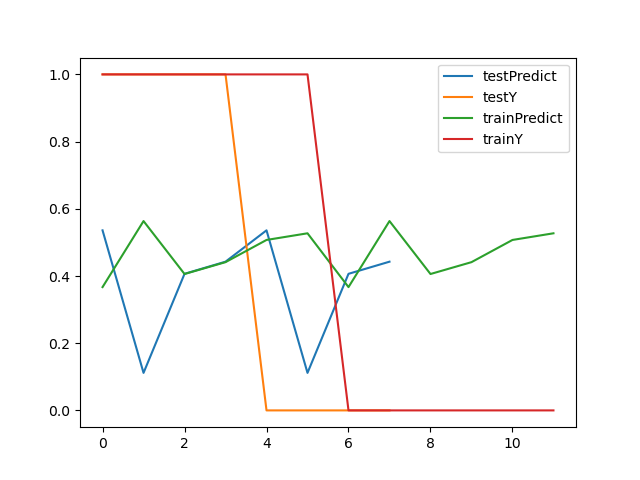

In [26]:
%matplotlib notebook
plt.plot(testPredict, label="testPredict")
plt.plot(testY, label="testY")
plt.plot(trainPredict, label="trainPredict")
plt.plot(trainY, label="trainY")
plt.legend()
plt.show()